In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random
import math

# Funções auxiliares

In [2]:

def visualizar_dataset(pasta_imgs, pasta_masks=None, pasta_labels=None, qtd=4, titulo="Amostra"):
    """
    Visualiza uma grade de imagens aleatórias do dataset, com suporte opcional 
    para sobreposição de máscaras de segmentação e bounding boxes (YOLO).

    Args:
        pasta_imgs (str): Caminho para o diretório das imagens originais.
        pasta_masks (str, optional): Caminho para o diretório das máscaras binárias.
        pasta_labels (str, optional): Caminho para o diretório dos labels .txt (YOLO).
        qtd (int): Número de imagens a serem visualizadas.
        titulo (str): Título geral da figura.
    """
    
    # Coleta de arquivos de imagem suportados
    extensoes = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    lista_imgs = []
    for ext in extensoes:
        lista_imgs.extend(glob.glob(os.path.join(pasta_imgs, ext)))
    
    if not lista_imgs:
        print(f"ERRO: Nenhuma imagem encontrada em {pasta_imgs}")
        return

    # Seleção aleatória de amostras
    amostras = random.sample(lista_imgs, min(qtd, len(lista_imgs)))
    num_amostras = len(amostras)
    
    # Configuração dinâmica do layout do grid (Max 4 colunas)
    max_cols = 4
    n_cols = min(num_amostras, max_cols)
    n_rows = math.ceil(num_amostras / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    
    # Normalização dos eixos para iteração linear
    if num_amostras > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    print(f"--- Visualizando: {titulo} ---")

    for i, ax in enumerate(axes):
        # Desativa eixos excedentes no grid
        if i >= num_amostras:
            ax.axis('off')
            continue
            
        img_path = amostras[i]
        basename = os.path.basename(img_path)
        nome_sem_ext = os.path.splitext(basename)[0]
        
        # Carregamento e conversão de cor
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # --- CAMADA 1: Sobreposição de Máscara (Segmentação) ---
        if pasta_masks:
            # Tenta encontrar máscara com extensão .png ou original
            mask_path = os.path.join(pasta_masks, nome_sem_ext + ".png")
            if not os.path.exists(mask_path):
                 mask_path = os.path.join(pasta_masks, basename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    # Garante que dimensões batem (resize nearest neighbor para não interpolar classes)
                    if mask.shape != (h, w):
                        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
                    
                    # Aplica overlay laranja
                    overlay = img.copy()
                    overlay[mask > 0] = [0, 100, 255] 
                    img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
        
        # --- CAMADA 2: Desenho das Bounding Boxes (YOLO) ---
        if pasta_labels:
            txt_path = os.path.join(pasta_labels, nome_sem_ext + ".txt")
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    for linha in f.readlines():
                        dados = linha.strip().split()
                        if len(dados) >= 5:
                            # Conversão: Normalized XYWH -> Pixel XYXY
                            xc, yc = float(dados[1]), float(dados[2])
                            wb, hb = float(dados[3]), float(dados[4])
                            
                            x1 = int((xc - wb/2) * w)
                            y1 = int((yc - hb/2) * h)
                            x2 = int((xc + wb/2) * w)
                            y2 = int((yc + hb/2) * h)
                            
                            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Plotagem
        ax.imshow(img)
        ax.set_title(basename, fontsize=9)
        ax.axis('off')

    plt.tight_layout()

In [3]:
class CorrosionDetector:
    def __init__(self):
        self.mean = None
        self.inv_cov = None
        self.trained = False

    def fit(self, image_paths, mask_paths):
        """
        Treina o modelo calculando a média e a matriz de covariância inversa 
        dos pixels de corrosão (distância de Mahalanobis).
        """
        print(f"[TREINO] Processando {len(image_paths)} imagens...")
        all_samples = []

        for img_path, mask_path in zip(image_paths, mask_paths):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None or mask is None: 
                continue
            
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            
            # Extração de pixels da região de interesse (ROI)
            pixels = img_lab[mask > 0]
            if len(pixels) > 0:
                all_samples.append(pixels)

        if not all_samples:
            raise ValueError("Erro: Nenhum pixel de referência encontrado para treino.")

        training_data = np.vstack(all_samples).astype(np.float32)
        
        # Cálculo dos parâmetros estatísticos
        self.mean = np.mean(training_data, axis=0)
        cov = np.cov(training_data, rowvar=False)
        
        # Regularização para evitar matriz singular
        cov += np.eye(cov.shape[0]) * 1e-6 
        self.inv_cov = np.linalg.inv(cov)
        
        self.trained = True
        print("[TREINO] Finalizado.")

    def get_distance_map(self, img):
        """Gera o mapa de distâncias de Mahalanobis para a imagem fornecida."""
        if not self.trained: 
            raise RuntimeError("Modelo não treinado.")
        
        h, w = img.shape[:2]
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab).astype(np.float32)
        img_flat = img_lab.reshape(-1, 3)
        
        delta = img_flat - self.mean
        temp = np.dot(delta, self.inv_cov)
        dist_sq = np.sum(temp * delta, axis=1)
        
        return np.sqrt(dist_sq).reshape(h, w)

    def predict(self, img, threshold):
        """
        Realiza a segmentação baseada no limiar de distância e aplica 
        pós-processamento morfológico.
        """
        dist_map = self.get_distance_map(img)
        mask = (dist_map <= threshold).astype(np.uint8) * 255
        
        # Pós-processamento morfológico (redução de ruído e fechamento de lacunas)
        kernel_noise = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_noise)
        
        kernel_merge = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_merge)
        
        return mask, dist_map

    def optimize_threshold_on_train_set(self, image_paths, label_paths):
        """
        Otimiza o limiar (threshold) buscando o maior 'Inside Ratio'.
        
        A métrica maximizada é:
            (Pixels segmentados DENTRO das boxes YOLO) / (Total de pixels segmentados)
            
        Args:
            image_paths: Lista de caminhos das imagens.
            label_paths: Lista de caminhos dos arquivos .txt (formato YOLO).
        """
        print(f"[OTIMIZAÇÃO] Iniciando busca pelo melhor limiar baseado no Inside Ratio...")
        
        all_dists = []
        all_box_masks = []

        # 1. Pré-processamento: Gerar mapas de distância e máscaras de caixas (vetorização)
        for img_path, lbl_path in zip(image_paths, label_paths):
            img = cv2.imread(img_path)
            if img is None: continue
            
            h, w = img.shape[:2]
            
            # Gera mapa de distâncias de Mahalanobis
            dist_map = self.get_distance_map(img)
            
            # Gera máscara binária baseada nas caixas do YOLO (1=dentro, 0=fora)
            boxes = parse_yolo_labels(lbl_path, (h, w))
            box_mask = np.zeros((h, w), dtype=np.uint8)
            for (x1, y1, x2, y2) in boxes:
                cv2.rectangle(box_mask, (x1, y1), (x2, y2), 1, -1) # Preenche com 1
            
            all_dists.append(dist_map.flatten())
            all_box_masks.append(box_mask.flatten())

        if not all_dists:
            raise ValueError("Nenhum dado válido para otimização.")

        # Concatena todos os pixels do dataset num array gigante
        y_dists = np.concatenate(all_dists)
        y_in_box = np.concatenate(all_box_masks) # Ground Truth "Grosseiro" (Boxes)

        # 2. Grid Search para maximizar o Inside Ratio
        thresholds = np.arange(1.0, 15.0, 0.2) # Range um pouco maior
        melhor_ratio = -1.0
        melhor_th = 3.0
        
        # Define um mínimo de pixels para evitar divisão por zero ou máscaras vazias 
        # (ex: 0.01% dos pixels totais devem ser ativados para considerar válido)
        min_pixels_ativados = len(y_dists) * 0.0001 

        for th in thresholds:
            # Predição vetorizada: 1 se distancia <= th, 0 caso contrário
            y_pred = (y_dists <= th)
            
            total_pred = np.sum(y_pred)
            
            # Se não previu quase nada, ignora (evita falsos 100% de precisão com 1 pixel)
            if total_pred < min_pixels_ativados:
                continue
                
            # Interseção: Pixel foi predito E está dentro da caixa
            intersection = np.sum(y_pred & (y_in_box == 1))
            
            # Ratio: % do que eu pintei que está dentro da caixa
            ratio = intersection / total_pred
            
            # Queremos o maior ratio. 
            # Em caso de empate, preferimos o maior threshold (captura mais corrosão mantendo a precisão)
            if ratio >= melhor_ratio:
                melhor_ratio = ratio
                melhor_th = th

        print(f"--> Melhor Limiar: {melhor_th:.1f} (Inside Ratio: {melhor_ratio:.2%})")
        
        # Retorna o valor exato, sem margem de segurança arbitrária, 
        # pois o inside_ratio já tende a ser conservador.
        return melhor_th

# ==========================================
# FUNÇÕES AUXILIARES
# ==========================================

def calculate_inside_ratio(mask_pred, yolo_boxes):
    """
    Calcula a proporção de pixels segmentados que estão dentro das 
    bounding boxes do YOLO.
    """
    total_pixels_detectados = np.count_nonzero(mask_pred)
    if total_pixels_detectados == 0: 
        return 0.0
    
    mask_yolo = np.zeros_like(mask_pred)
    for (x1, y1, x2, y2) in yolo_boxes:
        cv2.rectangle(mask_yolo, (x1, y1), (x2, y2), 255, -1)
        
    intersecao = cv2.bitwise_and(mask_pred, mask_yolo)
    pixels_dentro = np.count_nonzero(intersecao)
    
    return pixels_dentro / total_pixels_detectados

def parse_yolo_labels(txt_path, img_shape):
    """
    Converte anotações YOLO (coordenadas normalizadas) para bounding boxes 
    em pixels (x1, y1, x2, y2).
    """
    h_img, w_img = img_shape[:2]
    boxes = []
    
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for linha in f.readlines():
                dados = linha.strip().split()
                if len(dados) >= 5:
                    # Parseamento: class x_center y_center width height
                    x_c, y_c = float(dados[1]), float(dados[2])
                    w_n, h_n = float(dados[3]), float(dados[4])
                    
                    x_center, y_center = int(x_c * w_img), int(y_c * h_img)
                    w_box, h_box = int(w_n * w_img), int(h_n * h_img)
                    
                    x1 = int(x_center - w_box/2)
                    y1 = int(y_center - h_box/2)
                    x2 = int(x_center + w_box/2)
                    y2 = int(y_center + h_box/2)
                    boxes.append((x1, y1, x2, y2))
    return boxes

# Explorando o Data set


### Visão Geral
Este projeto utiliza o **[Corrosion Detect Dataset](https://www.kaggle.com/datasets/wednesday233/corrosion-detect-dataset)**, disponibilizado no Kaggle. O objetivo é treinar modelos de visão computacional para identificar e localizar áreas corroídas em estruturas navais.

### Características do Dataset
* **Domínio:** Inspeção estrutural naval (áreas de navios).
* **Volume de Dados:** 268 imagens.
* **Tipo de Anotação:** *Bounding Boxes* (Caixas Delimitadoras).
* **Formato dos Labels:** Compatível com **YOLO** (You Only Look Once).

### Desafios e Condições
O dataset apresenta cenários realistas e desafiadores para algoritmos de detecção de objetos, incluindo:
1.  **Variação de Iluminação:** Imagens capturadas sob diferentes condições de luz (sombras, superexposição).
2.  **Complexidade Visual:** Texturas de ferrugem misturadas com a pintura e estrutura do navio.
3.  **Escala:** Diferentes níveis de zoom e ângulos de captura das áreas afetadas.

---
> **Nota:** Todas as 268 imagens possuem seus respectivos arquivos de anotação (`.txt`) já formatados para treinamento direto em arquiteturas YOLO.

## Visualização de Dados e Ground Truth

A função `visualizar_dataset` permite uma inspeção visual rápida das amostras do dataset. Ela é fundamental para validar a integridade dos dados e a qualidade das anotações antes do treinamento.

**Funcionalidades:**
* **Imagens:** Carrega imagens aleatórias do diretório especificado.
* **Segmentação (Máscaras):** Sobrepõe a máscara binária em **laranja** (se fornecida).
* **Detecção (YOLO):** Desenha as *bounding boxes* em **verde** baseadas nos arquivos `.txt` (se fornecidos).

Isso permite verificar se:
1. As máscaras estão alinhadas corretamente com os objetos.
2. As coordenadas YOLO (normalizadas) estão sendo convertidas corretamente para pixels.
3. Não há corrupção nos arquivos de imagem.

--- Visualizando: Teste (Img + YOLO) ---


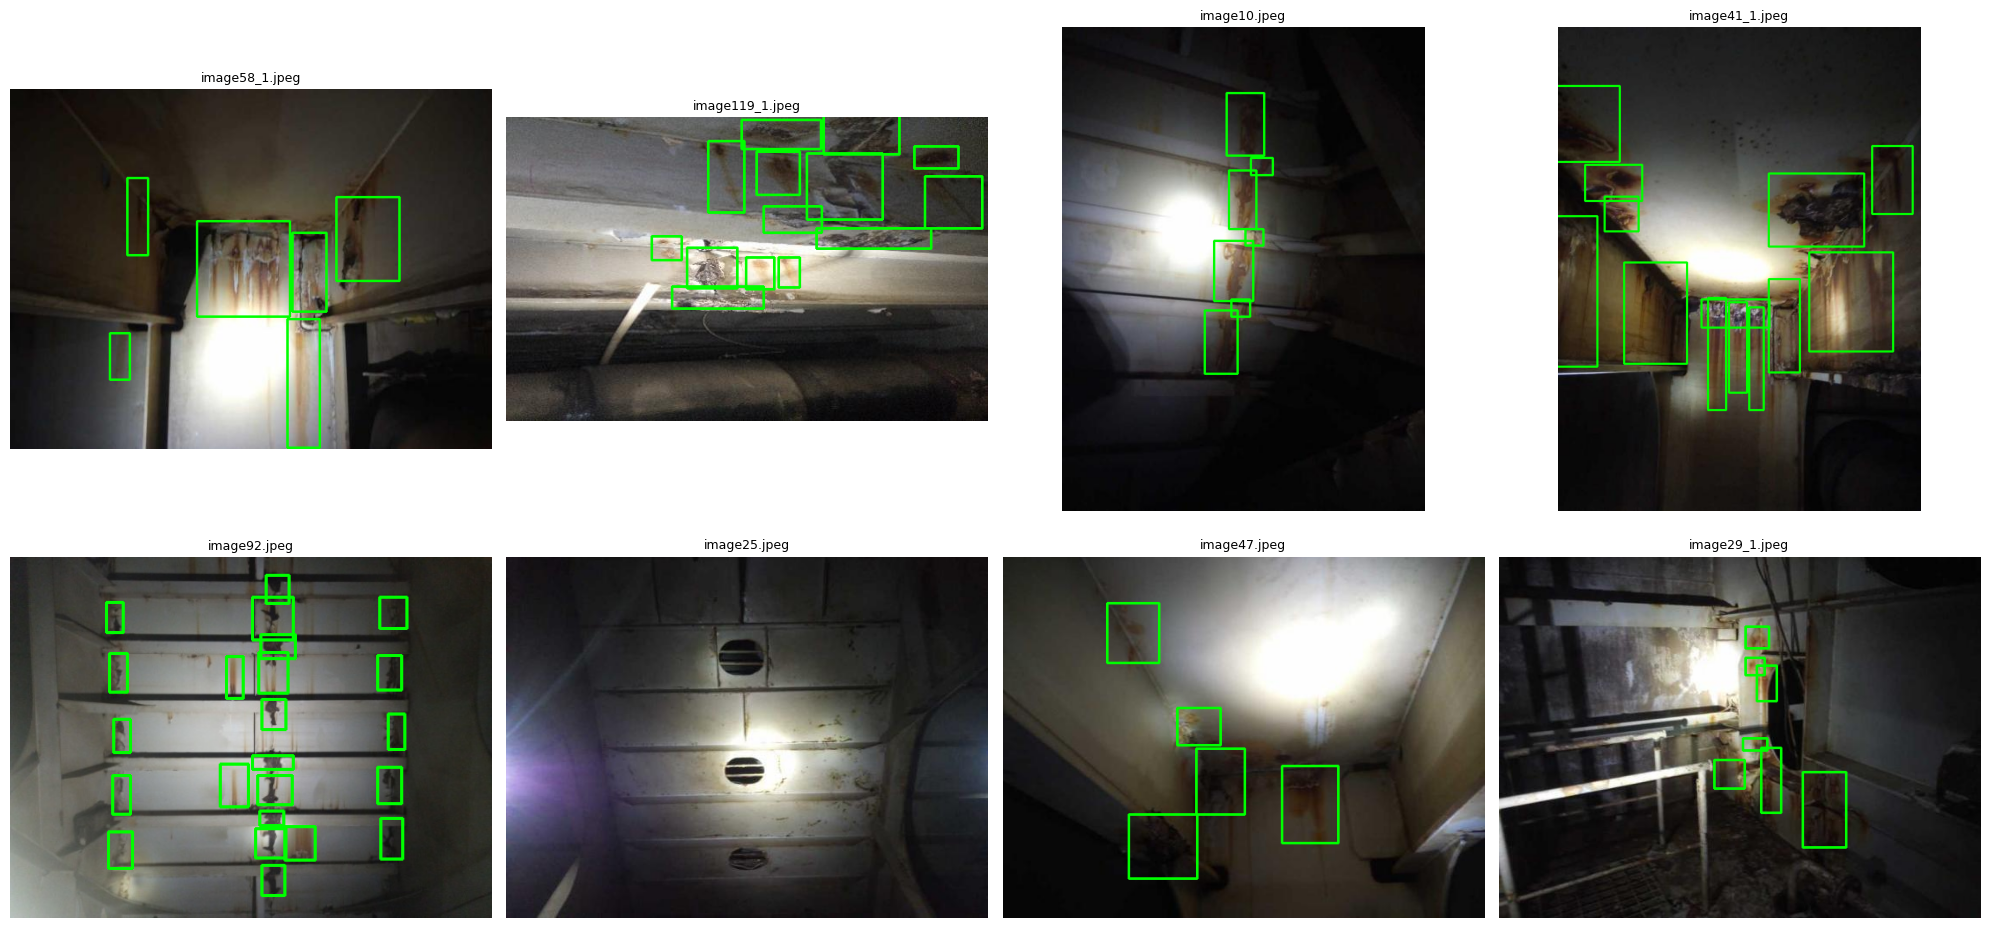

In [4]:
visualizar_dataset(
    pasta_imgs="corrosion detect/images", 
    pasta_labels="corrosion detect/labels", 
    qtd=8,
    titulo="Teste (Img + YOLO)"
)

### Análise da Qualidade das Anotações (Ground Truth)

Durante a análise exploratória dos dados, foram identificadas inconsistências nas anotações (*labels*) originais do dataset público, que podem impactar o treinamento do modelo YOLO:

1.  **Imprecisão das Bounding Boxes:**
    * Muitas caixas delimitadoras não cobrem a totalidade da área corroída, deixando "vazar" texturas de corrosão para o *background* (falso negativo local).
    * Outras caixas são excessivamente amplas, incluindo muita área sadia dentro da anotação.

2.  **Omissão de Instâncias (Missing Labels):**
    * Existem focos visíveis de corrosão que não foram anotados no dataset original.
    * *Impacto:* O modelo pode ser penalizado durante o treinamento por detectar corretamente uma corrosão que o anotador humano ignorou.

> **Consideração sobre Datasets Públicos:** Tais artefatos são comuns em datasets abertos ("in-the-wild"), onde o controle de qualidade da anotação nem sempre é rigoroso. A estratégia adotada assume esses ruídos como uma restrição intrínseca do projeto.

# Abordagem utilizando visão classica.

## Modelagem Estatística: Segmentação Manual e Distância de Mahalanobis

Como os bounding boxes não cobrem uma região completamente tomada pela corrosão, deve-se realizar uma segmentação manual de algumas imagens para servirem de treino para o algoritmo que será usado.

### 1. Metodologia de Amostragem e Anotação
Foi realizada uma segmentação manual fina para extrair amostras puras da classe "Corrosão".

* **Amostragem:** 8 imagens selecionadas aleatoriamente do dataset.
* **Ferramenta:** Script auxiliar `labeler.py` (anexo a este notebook).
* **Processo:** Criação de máscaras binárias manuais que delimitam a corrosão em nível de pixel, garantindo que nenhum pixel de fundo (background) contamine a estatística da amostra.

### 2. Fundamentação Matemática
A partir das máscaras geradas, extraem-se os vetores de características (cores) para o cálculo da **Matriz de Covariância** ($\Sigma$) e do **Vetor de Médias** ($\mu$).

O classificador utilizará a **Distância de Mahalanobis** como métrica de similaridade. Ao contrário da distância Euclidiana, a métrica de Mahalanobis considera a correlação entre as variáveis e a variância da distribuição:

$$
D_M(x) = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}
$$

> **Hipótese:** A distribuição de cores da corrosão forma um cluster elíptico no espaço de cores. O modelo "fitado" com Mahalanobis será capaz de identificar pixels corrosivos em novas imagens calculando a distância estatística de cada pixel em relação a essa distribuição padrão.

--- Visualizando: Mascaras (Img + YOLO) ---


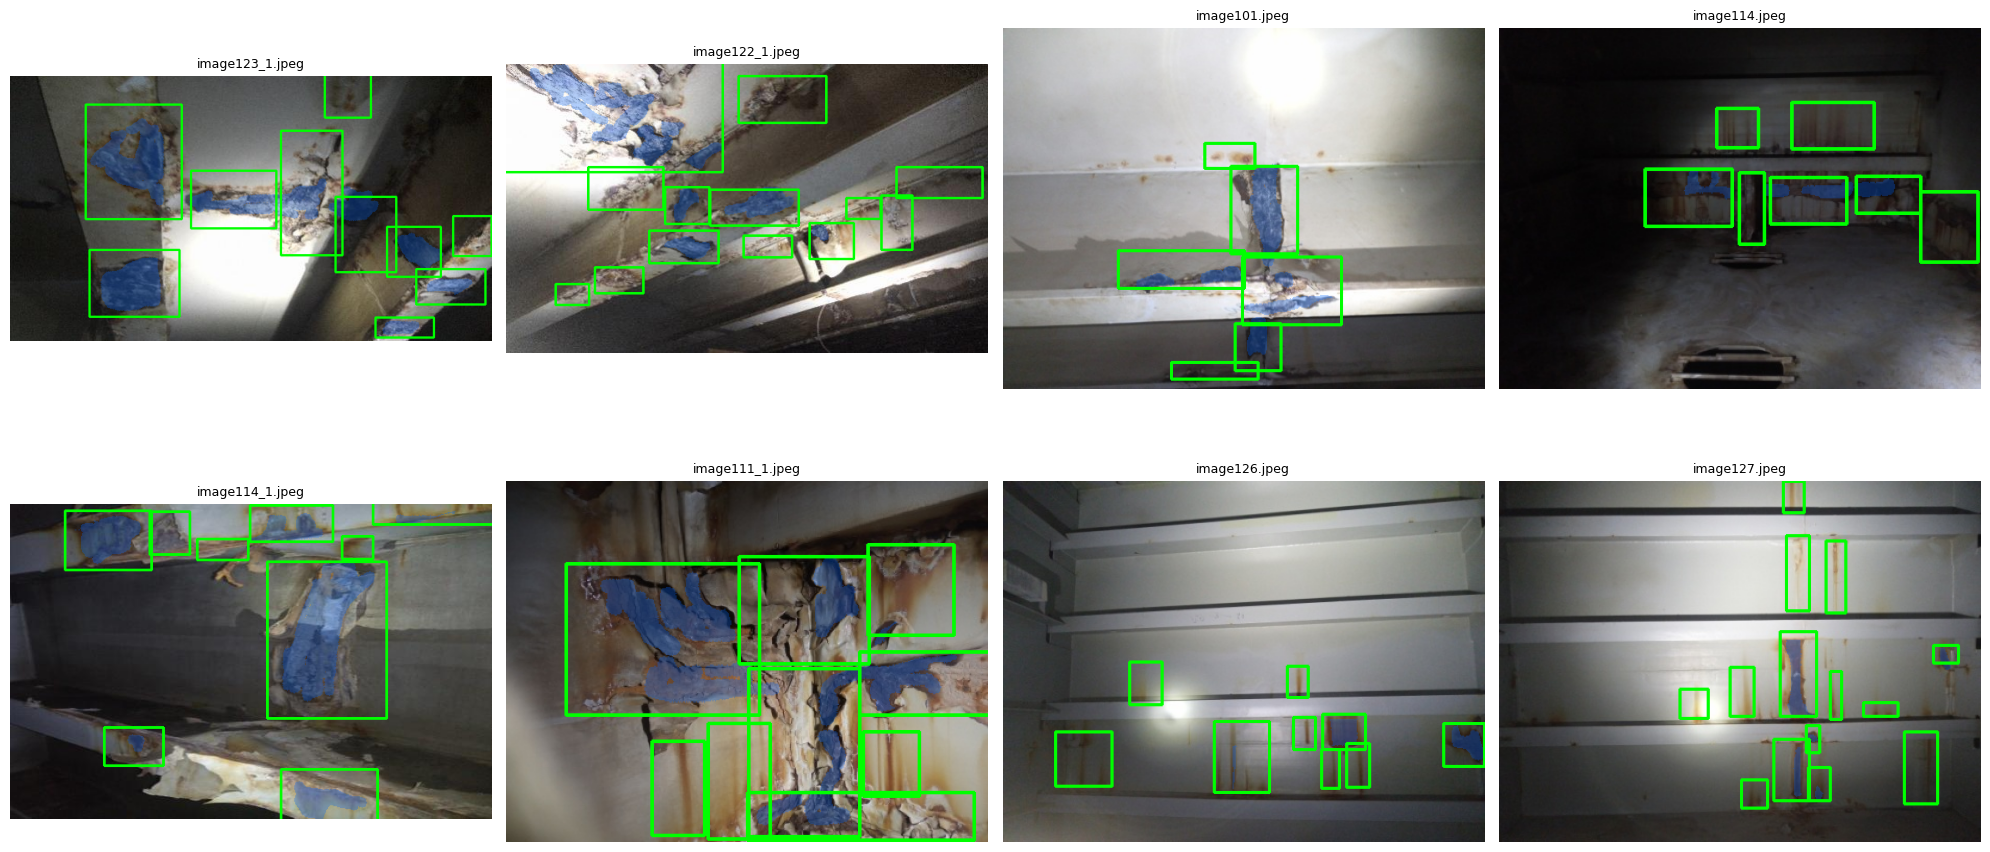

In [5]:
visualizar_dataset(
    pasta_imgs="corrosion detect/images_train",
    pasta_masks="corrosion detect/mask", 
    pasta_labels="corrosion detect/labels", 
    qtd=8,
    titulo="Mascaras (Img + YOLO)"
)

## Implementação da Classe: CorrosionDetector

Para encapsular a lógica estatística e permitir a reprodutibilidade, foi desenvolvida a classe `CorrosionDetector`. Esta estrutura gerencia todo o ciclo de vida do modelo, desde o treinamento com amostras manuais até a otimização de hiperparâmetros contra os dados do YOLO.

### 1. Espaço de Cores e Pré-processamento
Diferente da abordagem RGB padrão, o algoritmo converte as imagens para o espaço de cores **CIELAB (Lab)** antes do processamento.
* **Justificativa:** O canal **L** isola a luminosidade, enquanto **a** e **b** contêm a informação cromática. Isso torna o detector mais robusto a variações de iluminação (sombras e reflexos), focando na *cor* da ferrugem.

### 2. Treinamento e Regularização (Método `fit`)
O modelo calcula a estatística dos pixels de corrosão (Média $\mu$ e Covariância $\Sigma$).
* **Regularização Numérica:** Para evitar instabilidade numérica (matrizes singulares não inversíveis), aplica-se um fator de regularização ($\epsilon = 10^{-6}$) na diagonal da matriz de covariância:
    $$\Sigma_{reg} = \Sigma + \epsilon \cdot I$$

### 3. Pós-Processamento Morfológico (Método `predict`)
Após a segmentação inicial via Mahalanobis, aplicam-se operações morfológicas para limpar a máscara binária:
1.  **Abertura (Morphological Open):** Remove ruídos pequenos (salt-and-pepper) do fundo.
2.  **Fechamento (Morphological Close):** Preenche pequenos buracos dentro das áreas detectadas de corrosão, consolidando a detecção.



### 4. Otimização do Limiar via "Inside Ratio" (Método `optimize_threshold`)
Um dos maiores desafios é definir o valor de corte (threshold) da distância de Mahalanobis. Em vez de um valor arbitrário, implementou-se uma busca (Grid Search) para maximizar a consistência com as anotações YOLO.

A métrica utilizada é o **Inside Ratio** ($R_{in}$):

$$R_{in} = \frac{\text{Pixels Segmentados } \cap \text{ Bounding Box YOLO}}{\text{Total de Pixels Segmentados}}$$

> **Lógica:** Buscamos um limiar que maximize a quantidade de corrosão detectada *dentro* das caixas anotadas, penalizando segmentações que "vazam" excessivamente para áreas sadias. Isso alinha o modelo estatístico não-supervisionado com o conhecimento prévio (labels) do dataset.

In [6]:
# 1. Configuração
pasta_teste_raiz = "corrosion detect/images"
pasta_labels_teste = "corrosion detect/labels"
pasta_labels_treino = "corrosion detect/labels_train"
path_imgs_treino = sorted(glob.glob("corrosion detect/images_train/*.jpeg"))
path_masks_treino = sorted(glob.glob("corrosion detect/mask/*.png"))
path_labels_treino = sorted(glob.glob("corrosion detect/labels_train/*.txt"))


# Coleta imagens de teste
path_imgs_teste = []
for ext in ['*.jpeg', '*.jpg', '*.png']:
    path_imgs_teste.extend(glob.glob(os.path.join(pasta_teste_raiz, ext)))
path_imgs_teste.sort()

# 2. Treino
detector = CorrosionDetector()
detector.fit(path_imgs_treino, path_masks_treino)

best_th = detector.optimize_threshold_on_train_set(path_imgs_treino, path_labels_treino)

# 3. Processamento em Batch (Armazenar resultados)
results_data = []

print(f"Processando {len(path_imgs_teste)} imagens de teste...")

[TREINO] Processando 8 imagens...
[TREINO] Finalizado.
[OTIMIZAÇÃO] Iniciando busca pelo melhor limiar baseado no Inside Ratio...
--> Melhor Limiar: 1.0 (Inside Ratio: 44.83%)
Processando 268 imagens de teste...


## Avaliação Qualitativa e Quantitativa

Para validar a eficácia do método híbrido (Mahalanobis + YOLO), realiza-se uma varredura no conjunto de teste. O desempenho é mensurado pela métrica **Inside Ratio**, comparando a máscara segmentada com o *Ground Truth*.

A visualização abaixo apresenta uma **amostragem estratificada**:
1.  **Top Performers:** Casos onde a segmentação estatística melhor se alinhou às anotações manuais.
2.  **Worst Cases:** Casos de baixa concordância, úteis para diagnosticar falhas no limiar ou anotações incorretas no dataset original.
3.  **Random Samples:** Amostras aleatórias para verificar a generalização do modelo em cenários comuns.

*Legenda Visual:*
* <span style="color:red">**Vermelho:**</span> Máscara predita pelo algoritmo (Mahalanobis).
* <span style="color:green">**Verde:**</span> Bounding Box original (YOLO).

[INFO] Iniciando avaliação de 268 imagens de teste...
------------------------------------------------------------
RESULTADOS DA AVALIAÇÃO:
Média do Inside Ratio (amostras rotuladas): 33.96%
------------------------------------------------------------


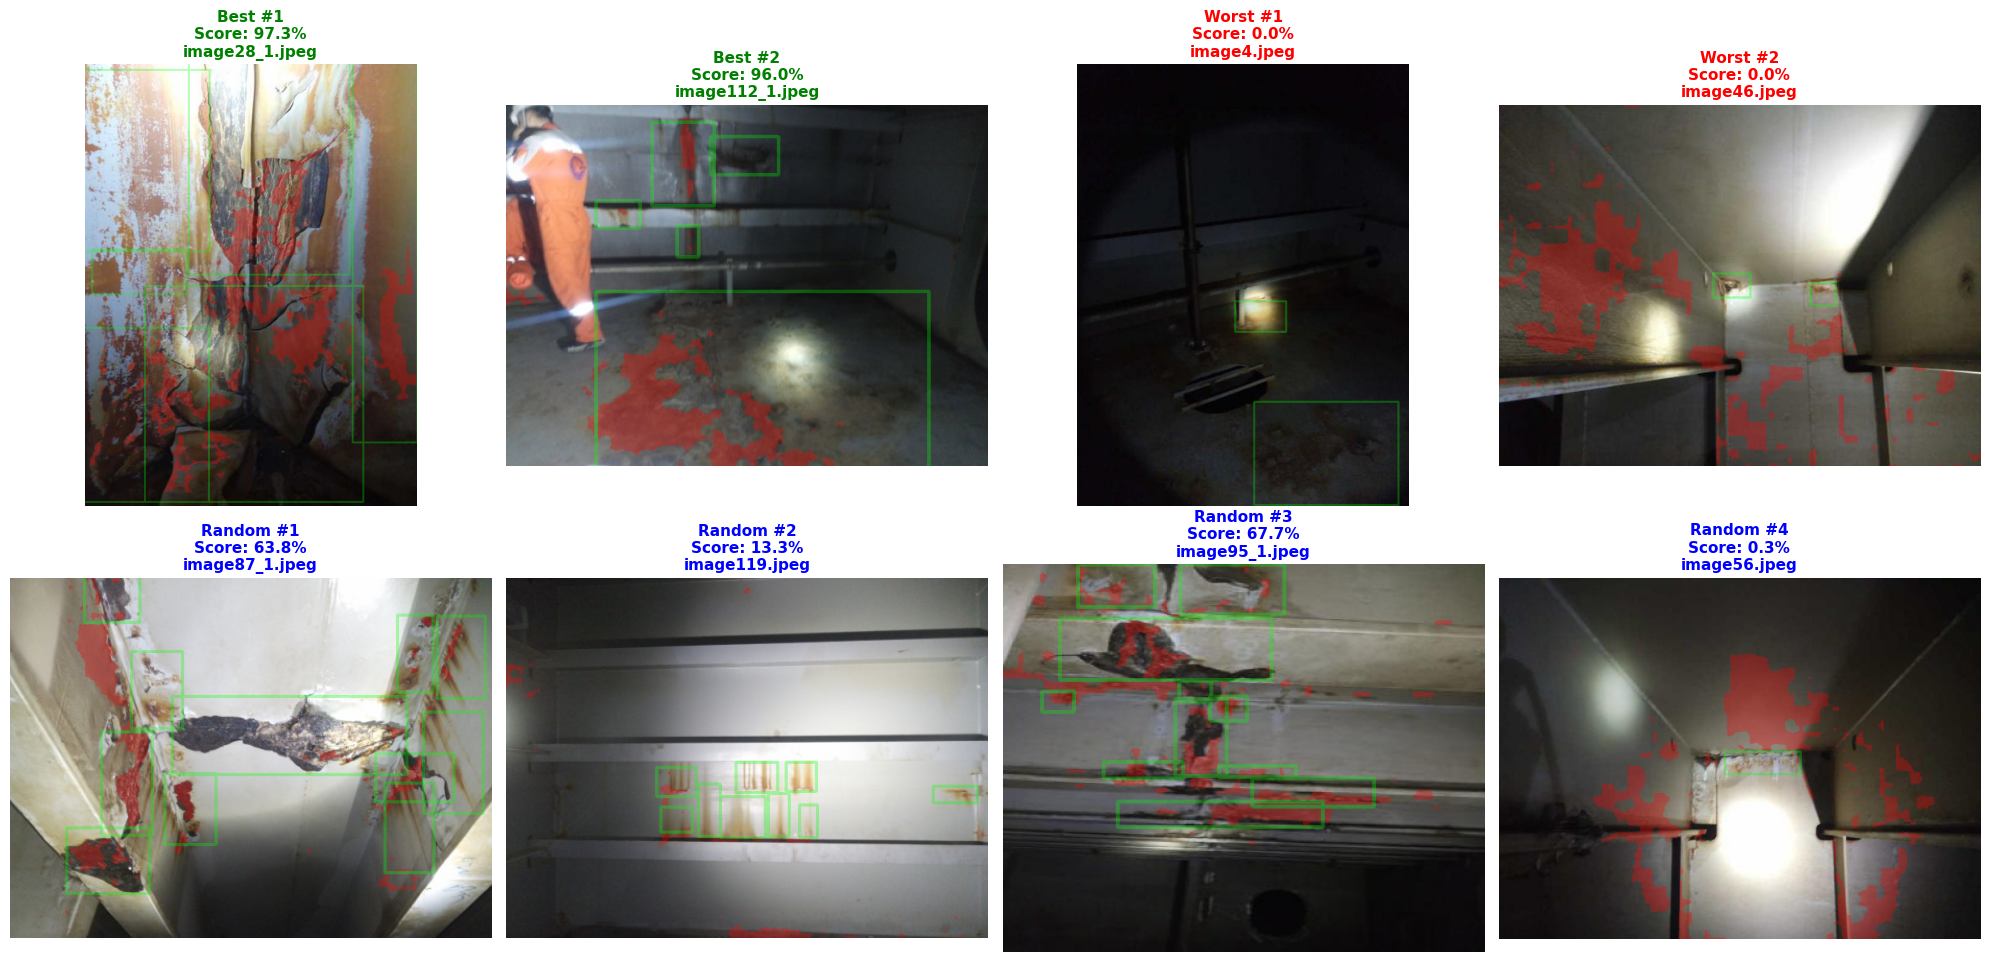

In [7]:
# ==============================================================================
# 1. PROCESSAMENTO E AVALIAÇÃO EM LOTE
# ==============================================================================
results_data = []

print(f"[INFO] Iniciando avaliação de {len(path_imgs_teste)} imagens de teste...")

for file_path in path_imgs_teste:
    # Carregamento da imagem
    img = cv2.imread(file_path)
    if img is None:
        continue
    
    # Inferência (Segmentação via Mahalanobis)
    mask, _ = detector.predict(img, threshold=best_th)
    
    # Carregamento do Ground Truth (YOLO)
    txt_filename = os.path.splitext(os.path.basename(file_path))[0] + ".txt"
    txt_path = os.path.join(pasta_labels_teste, txt_filename)
    
    gt_boxes = parse_yolo_labels(txt_path, img.shape)
    has_label = len(gt_boxes) > 0
    
    # Cálculo da Métrica (Inside Ratio)
    score = calculate_inside_ratio(mask, gt_boxes) if has_label else 0.0
    
    # --- Geração do Overlay Visual ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay_layer = img_rgb.copy()
    
    # Camada de Segmentação (Vermelho)
    overlay_layer[mask > 0] = [255, 0, 0] 
    
    # Camada de Ground Truth (Verde - Bounding Boxes)
    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(overlay_layer, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Fusão (Alpha Blending): 70% Imagem Original + 30% Overlay
    final_vis = cv2.addWeighted(img_rgb, 0.7, overlay_layer, 0.3, 0)
    
    results_data.append({
        'filename': os.path.basename(file_path),
        'vis': final_vis,
        'score': score,
        'has_label': has_label,
        'id': id(final_vis) # Identificador único para filtragem posterior
    })

# ==============================================================================
# 2. ESTATÍSTICAS E AMOSTRAGEM ESTRATIFICADA
# ==============================================================================

# Filtragem apenas para imagens com anotação válida
labeled_results = [r for r in results_data if r['has_label']]
scores_validos = [r['score'] for r in labeled_results]

# Cálculo da performance média global
global_mean_score = np.mean(scores_validos) if scores_validos else 0.0

# Ordenação para seleção de extremos
# Melhores casos (Top 2)
sorted_desc = sorted(labeled_results, key=lambda x: x['score'], reverse=True)
top_samples = sorted_desc[:2]

# Piores casos (Bottom 2) - Identificação de falhas críticas
sorted_asc = sorted(labeled_results, key=lambda x: x['score'])
worst_samples = sorted_asc[:2]

# Amostragem Aleatória (Random 4)
# Remove amostras já selecionadas nos grupos Top/Worst para garantir variedade
selected_ids = {r['id'] for r in top_samples + worst_samples}
pool_remaining = [r for r in results_data if r['id'] not in selected_ids]

# Safety check para datasets pequenos
n_random = min(4, len(pool_remaining))
random_samples = random.sample(pool_remaining, n_random)

# Consolidação da lista final de visualização
display_queue = top_samples + worst_samples + random_samples
display_labels = ["Best #1", "Best #2", "Worst #1", "Worst #2"] + [f"Random #{i+1}" for i in range(n_random)]

# ==============================================================================
# 3. PLOTAGEM DOS RESULTADOS
# ==============================================================================

print("-" * 60)
print(f"RESULTADOS DA AVALIAÇÃO:")
print(f"Média do Inside Ratio (amostras rotuladas): {global_mean_score:.2%}")
print("-" * 60)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (ax, sample) in enumerate(zip(axes, display_queue)):
    ax.imshow(sample['vis'])
    
    # Definição do status e cor do título
    if sample['has_label']:
        score_text = f"{sample['score']:.1%}"
    else:
        score_text = "N/A"
        
    # Código de cores para os títulos
    if i < 2: 
        title_color, category = 'green', display_labels[i]  # Melhores
    elif i < 4: 
        title_color, category = 'red', display_labels[i]    # Piores
    else: 
        title_color, category = 'blue', display_labels[i]   # Aleatórios

    ax.set_title(f"{category}\nScore: {score_text}\n{sample['filename']}", 
                 color=title_color, fontsize=11, fontweight='bold')
    ax.axis('off')

# Ocultar eixos vazios se houver menos de 8 imagens
for j in range(len(display_queue), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Abordagem utilizando aprendizagem profunda